In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
! kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
cat-dog-images-for-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import Sequential, regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout


In [8]:
df = pd.read_csv('/content/cat_dog.csv')

In [9]:
df.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [10]:
df.shape

(25000, 2)

In [11]:
df['labels'].value_counts()

,count
labels,
1,12500
0,12500


No Imbalance in the data

In [12]:
#Creating a list of image file paths and labels
image_paths = ['/content/cat_dog/' + fname for fname in df['image']]
labels = df['labels'].values

#Defing a function to load and preprocess images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize pixel values
    return image, label

#Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [13]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [14]:
from sklearn.model_selection import train_test_split
   # Calculate the split sizes based on the original dataset size
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = int(0.2 * dataset_size)   # 20% for testing

   # Create train and test datasets using take and skip
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [15]:
#creating a CNN model

model = Sequential()

model.add(Conv2D(8,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(16,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(32,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 537,137 (2.05 MB)

 Trainable params: 536,129 (2.05 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [19]:
history = model.fit(train_dataset,epochs=25,validation_data=test_dataset,callbacks=[early_stopping])

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.6195 - loss: 2.7114 - val_accuracy: 0.6390 - val_loss: 1.0570
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.7400 - loss: 0.8176 - val_accuracy: 0.6736 - val_loss: 0.9272
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.7908 - loss: 0.7109 - val_accuracy: 0.6146 - val_loss: 0.9239
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.8346 - loss: 0.6748 - val_accuracy: 0.8246 - val_loss: 0.6627
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 119ms/step - accuracy: 0.8629 - loss: 0.6138 - val_accuracy: 0.8768 - val_loss: 0.5814
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.8789 - loss: 0.5857 - val_accuracy: 0.8576 - val_loss: 0.6131
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.8799 - loss: 0.5692 - val_accuracy: 0.8372 - val_loss: 0.6712
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.8917 - loss: 0

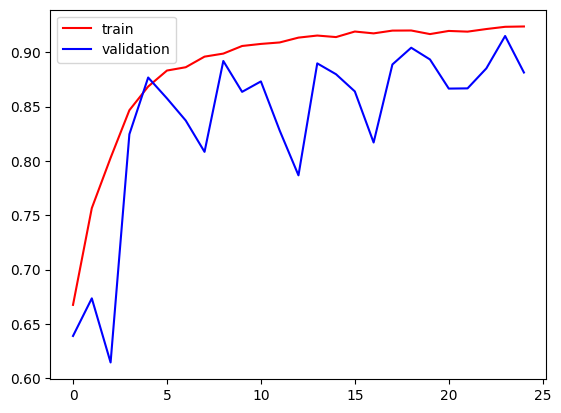

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

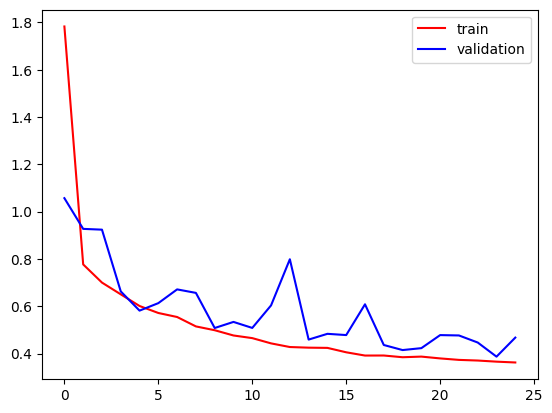

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()